In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
prms_speed = pd.read_csv('exponential_speed_prms.csv')
prms_accuracy = pd.read_csv('exponential_accuracy_prms.csv')
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//10*10

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [4]:
prms_speed

,sbj,b0,lambda,delta0,delta1,t0,sigma,mean_z,std_z,G2,BIC
0,S10_epo,0.589955,0.767680,3.309903,0.565592,0.256351,0.312312,0.276774,0.088388,-1233.339584,-1195.425775
1,S11_epo,0.672463,0.434563,3.105386,0.551332,0.327847,0.279963,0.387775,0.087389,-424.025222,-386.079068
2,S12_epo,0.728476,0.577962,2.029321,0.234339,0.318921,0.329169,0.328788,0.108616,-408.544627,-370.609235
3,S13_epo,1.161763,0.725601,5.000000,0.916739,0.358732,0.288384,0.358174,0.110838,-881.146085,-843.199931
4,S14_epo,0.900784,2.000000,4.296964,0.688064,0.294954,0.254609,0.288417,0.073659,-1916.322923,-1878.376769
5,S15_epo,0.625254,1.298730,3.788211,0.719843,0.299156,0.246223,0.313812,0.078666,-1094.041987,-1056.149839
6,S16_epo,0.797992,1.270906,3.826961,0.710175,0.288477,0.239382,0.285201,0.071980,-1536.980930,-1499.056321
7,S17_epo,0.819716,0.734831,3.241974,0.639618,0.322278,0.335079,0.336783,0.109190,-479.010544,-441.064390
8,S18_epo,0.691570,0.555814,2.891802,0.611586,0.232163,0.402653,0.302441,0.098073,-339.560843,-301.614689
9,S19_epo,0.528860,0.052838,1.867019,0.367134,0.210729,0.416359,0.277899,0.102252,-473.047060,-435.111668


In [5]:
RT = np.array([])
Cont = np.array([])
SBJ = np.array([])

for i in tqdm(range(prms_speed.sbj.unique().shape[0])):
    sbj = prms_speed.sbj.unique()[i]
    b0 = prms_speed['b0'].values[i]
    lamda = prms_speed['lambda'].values[i]
    delta0 = prms_speed['delta0'].values[i]
    delta1 = prms_speed['delta1'].values[i]
    t0 = prms_speed['t0'].values[i]
    
    ub = lambda t: b0 * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t) 
    
    sbj_data = data_speed[data_speed['participant']==sbj].reset_index(drop=True)
    contrast = sbj_data.contrast.values
    
    rt = []
    
    for c in contrast:
        delta = delta0 - delta1*np.log(c)
        rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))
    
    RT = np.concatenate([RT, rt])
    Cont = np.concatenate([Cont, contrast])
    SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])
    
pred_speed = pd.DataFrame({'sbj': SBJ,
                           'rt': np.abs(RT),
                           'accuracy': RT>0,
                           'contrast': Cont,
                           'g_contrast': Cont//10*10})        

100%|█████████████████████████████████████████| 26/26 [00:09<00:00,  2.89it/s]


In [6]:
RT = np.array([])
Cont = np.array([])
SBJ = np.array([])

for i in tqdm(range(prms_accuracy.sbj.unique().shape[0])):
    sbj = prms_accuracy.sbj.unique()[i]
    b0 = prms_accuracy['b0'].values[i]
    lamda = prms_accuracy['lambda'].values[i]
    delta0 = prms_accuracy['delta0'].values[i]
    delta1 = prms_accuracy['delta1'].values[i]
    t0 = prms_accuracy['t0'].values[i]
    
    ub = lambda t: b0 * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t) 
    
    sbj_data = data_accuracy[data_accuracy['participant']==sbj].reset_index(drop=True)
    contrast = sbj_data.contrast.values
    
    rt = []
    
    for c in contrast:
        delta = delta0 - delta1*np.log(c)
        rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))
    
    RT = np.concatenate([RT, rt])
    Cont = np.concatenate([Cont, contrast])
    SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])
    
pred_accuracy = pd.DataFrame({'sbj': SBJ,
                              'rt': np.abs(RT),
                              'accuracy': RT>0,
                              'contrast': Cont,
                              'g_contrast': Cont//10*10})   

100%|█████████████████████████████████████████| 26/26 [00:16<00:00,  1.58it/s]


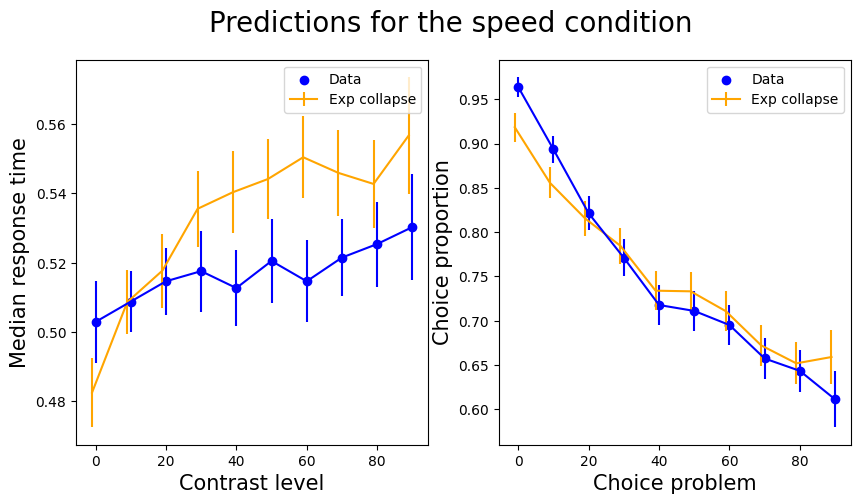

In [7]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)

se = pred_speed.groupby(by='g_contrast')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_speed.shape[0])
plt.errorbar(x=-1 + pred_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_speed.groupby(by='g_contrast')['rt'].median(),
             yerr=h, label='Exp collapse', c='orange');

se = data_speed.groupby(by='g_contrast')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_speed.shape[0])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['rt'].median(), 
            yerr=h, c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['rt'].median(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Median response time', fontsize=15)
plt.legend();

plt.subplot(122)
se = pred_speed.groupby(by='g_contrast')['accuracy'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_speed.shape[0])
plt.errorbar(x=-1 + pred_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_speed.groupby(by='g_contrast')['accuracy'].mean(),
             yerr=h, label='Exp collapse', c='orange');

se = data_speed.groupby(by='g_contrast')['correct'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_speed.shape[0])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
            yerr=h, c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');
plt.xlabel('Choice problem', fontsize=15)
plt.ylabel('Choice proportion', fontsize=15)
plt.legend();

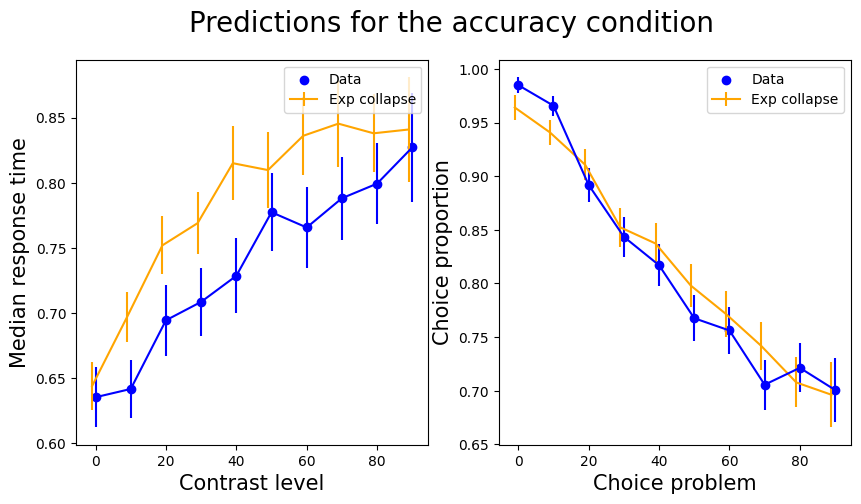

In [8]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the accuracy condition', fontsize=20)

plt.subplot(121)

se = pred_accuracy.groupby(by='g_contrast')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_accuracy.shape[0])
plt.errorbar(x=-1 + pred_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_accuracy.groupby(by='g_contrast')['rt'].median(),
             yerr=h, label='Exp collapse', c='orange');

se = data_accuracy.groupby(by='g_contrast')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_accuracy.shape[0])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['rt'].median(), 
            yerr=h, c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['rt'].median(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Median response time', fontsize=15)
plt.legend();

plt.subplot(122)
se = pred_accuracy.groupby(by='g_contrast')['accuracy'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_accuracy.shape[0])
plt.errorbar(x=-1 + pred_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_accuracy.groupby(by='g_contrast')['accuracy'].mean(),
             yerr=h, label='Exp collapse', c='orange');

se = data_accuracy.groupby(by='g_contrast')['correct'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., data_accuracy.shape[0])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
            yerr=h, c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');
plt.xlabel('Choice problem', fontsize=15)
plt.ylabel('Choice proportion', fontsize=15)
plt.legend();